In [1]:
"""
Imports necessary for this notebook
"""
import os 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io as sio
import shdom
from scipy.ndimage import center_of_mass



In [2]:
def calccenterofmass(droplets):
    lwc = droplets.lwc.data
    mx = np.sum(np.sum(lwc,2),1)
    my = np.sum(np.sum(lwc,2),0)
    mz = np.sum(np.sum(lwc,0),0)
    com_x = sum(mx * droplets.grid.x)/sum(mx)
    com_y = sum(my * droplets.grid.y)/sum(my)
    com_z = sum(mz * droplets.grid.z)/sum(mz)
    return com_x, com_y, com_z

In [3]:

"""
Set settings
"""
#355, 380, 445, 470, 555, 660, 865, 935
wavelengths = [0.355, 0.935]
vel_cloud = np.array([0.0,0.0,0.0]) # m/s
vel_camera = 45 # m/s
camera_height = 3 #km
# A fly over from West to East (positive y-axis direction)
# camera_zenith_list = [70.5, 60, 45.6, 26.1, 0, 26.1, 45.6, 60, 70.5]
# camera_azimuth_list = [-90, -90, -90, -90, 0, 90, 90, 90, 90]
camera_zenith_list = [70.5, 0, 70.5]
camera_azimuth_list = [-90, 0, 90]
output_dir = 'experiments/rico52x57x26_velocity_0_0_9img_perspective/dynamic_medium_Multispectral'

# sun
sun_azimuth=65
sun_zenith=135

# solver
iter = 100

# Mie scattering for water droplets
mie_table_paths = [
    '../mie_tables/polydisperse/Water_{}nm.scat'.format(shdom.int_round(wavelength)) 
    for wavelength in wavelengths
]

solar_spectrum = shdom.SolarSpectrum('../ancillary_data/SpectralSolar_MODWehrli_1985_WMO.npz')
solar_fluxes = solar_spectrum.get_monochrome_solar_flux(wavelengths)
solar_fluxes = solar_fluxes / max(solar_fluxes)


# Generate a Microphysical medium
droplets = shdom.MicrophysicalScatterer()
droplets.load_from_csv('../synthetic_cloud_fields/jpl_les/rico52x57x26.txt', veff=0.1)

com_x, com_y, com_z = calccenterofmass(droplets=droplets)
com = np.array([com_x, com_y, com_z])

L_list = (np.sign(camera_azimuth_list)) * (camera_height - com_z) * np.tan(np.deg2rad(camera_zenith_list) )

time_list = L_list *1e3 / vel_camera #sec
camera_position_list = np.zeros([L_list.shape[0],3])

# move the camera instead of the cloud
camera_position_list[:, 0] = com_x
camera_position_list[:, 1] = com_y + np.asarray(L_list)
camera_position_list[:, 2] = camera_height

# Rayleigh scattering for air molecules up to 20 km
df = pd.read_csv('../ancillary_data/AFGL_summer_mid_lat.txt', comment='#', sep=' ')
temperatures = df['Temperature(k)'].to_numpy(dtype=np.float32)
altitudes = df['Altitude(km)'].to_numpy(dtype=np.float32)
temperature_profile = shdom.GridData(shdom.Grid(z=altitudes), temperatures)
air_grid = shdom.Grid(z=np.linspace(0, 20, 20))
air = shdom.MultispectralScatterer()

In [4]:
for wavelength, table_path in zip(wavelengths, mie_table_paths):  
    # Molecular Rayleigh scattering
    rayleigh = shdom.Rayleigh(wavelength)
    rayleigh.set_profile(temperature_profile.resample(air_grid))
    air.add_scatterer(rayleigh.get_scatterer())
    
    # Droplet Mie scattering
    mie = shdom.MiePolydisperse()
    mie.read_table(table_path)
    droplets.add_mie(mie)
    


Reading mie table from file: ../mie_tables/polydisperse/Water_355nm.scat
Reading mie table from file: ../mie_tables/polydisperse/Water_935nm.scat


In [5]:
dynamic_scatterer = shdom.DynamicScatterer()
dynamic_scatterer.generate_dynamic_scatterer(scatterer=droplets, time_list=time_list, scatterer_velocity_list=vel_cloud)
dynamic_medium = shdom.DynamicMedium(dynamic_scatterer,air=air)

In [6]:
scene_params_list = []
numerical_params_list =[]
for wavelength, solar_flux in zip(wavelengths, solar_fluxes):
    scene_params = shdom.SceneParameters(
        wavelength=wavelength,
        source=shdom.SolarSource(azimuth=sun_azimuth, zenith=sun_zenith, flux=solar_flux)
    )
    scene_params_list.append(scene_params)
    numerical_params = shdom.NumericalParameters(num_mu_bins=8,num_phi_bins=16)
    numerical_params_list.append(numerical_params)
dynamic_solver = shdom.DynamicRteSolver(scene_params=scene_params_list,numerical_params=numerical_params_list)
dynamic_solver.set_dynamic_medium(dynamic_medium)
dynamic_solver.solve(maxiter=iter)

In [7]:
projections = shdom.MultiViewProjection()

for camera_azimuth,camera_zenith,camera_position in zip(camera_azimuth_list,camera_zenith_list,camera_position_list):
     
    if 1:
         projection = (
                shdom.PerspectiveProjection(fov=30, 
                nx=200, ny=200, x=camera_position[0], y=camera_position[1],
                z=camera_position[2])
            )  
         projection.look_at_transform(point=com, up=[1.0, 0.0, 0.0])
         projections.add_projection(projection)
    else:
        projection.add_projection(
            shdom.OrthographicProjection(droplets.bounding_box,x_resolution=0.01,
                                         y_resolution=0.01,azimuth=camera_zenith,zenith=camera_zenith)
            
        )

In [8]:
dynamic_camera = shdom.DynamicCamera(shdom.RadianceSensor(), projections)
images = dynamic_camera.render(dynamic_solver,n_jobs=40)

In [9]:
measurements = shdom.DynamicMeasurements(dynamic_camera, images=images, wavelength=wavelengths,time_list=time_list)

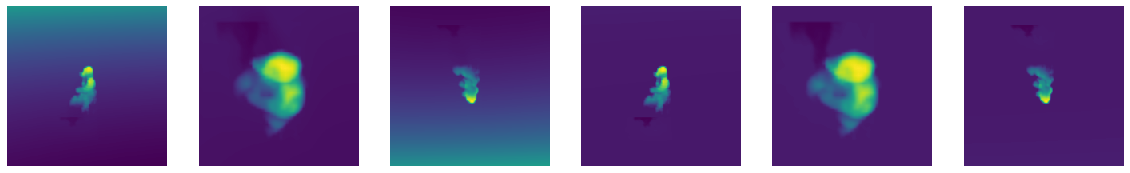

In [10]:
%matplotlib inline
f, axarr = plt.subplots(1, len(images), figsize=(20, 20))
for ax, image in zip(axarr, images):
    ax.imshow(image)
    ax.invert_xaxis() 
    ax.invert_yaxis() 
    ax.axis('off')

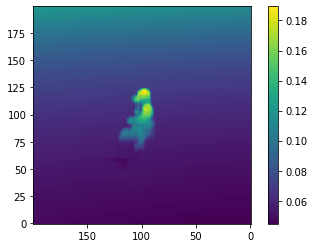

In [11]:
im = images[0]
plt.imshow(im)
plt.gca().invert_yaxis() 
plt.gca().invert_xaxis() 
plt.colorbar()


In [12]:
shdom.save_dynamic_forward_model(output_dir, dynamic_medium, dynamic_solver, measurements)

In [13]:
a,b,c = shdom.load_dynamic_forward_model(output_dir)
print()